# NHL Data Pipeline Demo

This notebook demonstrates how to use the improved NHL data pipeline for pool optimization.

## Features:
- Download and validate NHL data
- Process player statistics
- Create training datasets for machine learning
- Prepare current season data for predictions
- Data quality assessment and validation

## Setup and Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import logging
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Import our modules
from config import config, ProjectConfig
from data_pipeline import NHLDataPipeline
from data_validation import DataValidator
import data_download
import process_data

# Setup logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

# Try different matplotlib styles
try:
    plt.style.use('seaborn-v0_8')
except:
    try:
        plt.style.use('seaborn')
    except:
        pass  # Use default style

print("✅ All imports successful!")
print(f"📊 Current season: {config.data.current_season}")
print(f"🏒 Training seasons: {config.data.training_seasons}")

✅ All imports successful!
📊 Current season: 20232024
🏒 Training seasons: ['20202021', '20212022', '20222023', '20232024']


## Configuration Management

The new configuration system allows easy customization of settings.

In [2]:
# View current configuration
print("🔧 Current Configuration:")
print(f"Data directory: {config.data.base_data_dir}")
print(f"Current season: {config.data.current_season}")
print(f"Training seasons: {config.data.training_seasons}")
print(f"Salary cap: ${config.pool.salary_cap:,}")
print(f"Position limits: {config.pool.max_attackers}A / {config.pool.max_defensemen}D / {config.pool.max_goalies}G")
print(f"Min games threshold: {config.pool.min_games_threshold}")
print(f"API delay: {config.api.request_delay}s")

# Validate configuration
is_valid = config.validate()
print(f"\n✅ Configuration valid: {is_valid}")

🔧 Current Configuration:
Data directory: data
Current season: 20232024
Training seasons: ['20202021', '20212022', '20222023', '20232024']
Salary cap: $88,000,000
Position limits: 12A / 6D / 2G
Min games threshold: 100
API delay: 1.0s

✅ Configuration valid: True


In [3]:
# Optional: Customize configuration for this session
# Uncomment and modify as needed

# config.data.current_season = "20232024"
# config.data.training_seasons = ["20202021", "20212022", "20222023", "20232024"]
# config.pool.min_games_threshold = 100
# config.api.request_delay = 1.5  # Slower API calls if needed

print("⚙️ Configuration customized for this session")

⚙️ Configuration customized for this session


## Initialize Data Pipeline

Create the main pipeline object that will handle all data operations.

In [4]:
# Initialize the data pipeline
pipeline = NHLDataPipeline()

print(f"🚀 Pipeline initialized for seasons: {pipeline.seasons}")
print(f"📁 Data will be stored in: {config.data.data_path}")

# Create data directory if it doesn't exist
config.data.data_path.mkdir(exist_ok=True)
print("📂 Data directory ready")

🚀 Pipeline initialized for seasons: ['20202021', '20212022', '20222023', '20232024']
📁 Data will be stored in: data
📂 Data directory ready


## Data Download and Validation

Download NHL data for all required seasons with automatic validation.

In [5]:
# Check current data status
print("🔍 Checking existing data...")
validation_results = pipeline.validate_data_integrity()

print(f"Valid seasons: {len(validation_results['valid_seasons'])}/{validation_results['seasons_checked']}")
print(f"Total teams found: {validation_results['total_teams']}")
print(f"Total players found: {validation_results['total_players']}")

if validation_results['invalid_seasons']:
    print("\n⚠️ Issues found:")
    for issue in validation_results['invalid_seasons']:
        print(f"  - {issue}")

if validation_results['data_quality_issues']:
    print("\n⚠️ Data quality issues:")
    for issue in validation_results['data_quality_issues']:
        print(f"  - {issue}")

2025-09-18 23:52:54,420 - INFO - Validating data integrity
2025-09-18 23:52:54,420 - INFO - Validation complete: 0/4 seasons valid


🔍 Checking existing data...
Valid seasons: 0/4
Total teams found: 0
Total players found: 0

⚠️ Issues found:
  - 20202021: Missing players data
  - 20212022: Missing players data
  - 20222023: Missing players data
  - 20232024: Missing players data


In [6]:
# Download missing data
print("📥 Starting data download...")
print("This may take several minutes depending on what data is missing.")

# Set force_refresh=True to re-download everything, False to only download missing files
download_results = pipeline.download_all_data(force_refresh=False)

print("\n📊 Download Results:")
for season, success in download_results.items():
    status = "✅" if success else "❌"
    print(f"  {status} Season {season}: {success}")

successful_downloads = sum(download_results.values())
print(f"\n🎯 Successfully downloaded: {successful_downloads}/{len(download_results)} seasons")

2025-09-18 23:52:54,426 - INFO - Starting data download for seasons: ['20202021', '20212022', '20222023', '20232024']
2025-09-18 23:52:54,426 - INFO - Downloading data for season 20202021
2025-09-18 23:52:54,426 - INFO - Starting complete data download for season 20202021
2025-09-18 23:52:54,428 - INFO - Downloading player points for season 20202021 (attempt 1/3)


📥 Starting data download...
This may take several minutes depending on what data is missing.


2025-09-18 23:52:55,022 - INFO - Successfully downloaded 802 player records for season 20202021
2025-09-18 23:52:56,023 - INFO - Downloading season standings for 20202021 (attempt 1/3)
2025-09-18 23:52:56,296 - INFO - Successfully downloaded season standings for 20202021
2025-09-18 23:52:57,297 - INFO - Player points data for 20202021 already exists, skipping download
2025-09-18 23:52:57,313 - INFO - Found 31 teams for season 20202021: ['EDM', 'BOS', 'TOR', 'COL', 'CHI', 'WPG', 'PIT', 'VGK', 'FLA', 'STL', 'NYR', 'CAR', 'WSH', 'MIN', 'DAL', 'LAK', 'VAN', 'SJS', 'CGY', 'TBL', 'NYI', 'MTL', 'CBJ', 'ARI', 'PHI', 'BUF', 'DET', 'OTT', 'NJD', 'ANA', 'NSH']
2025-09-18 23:52:57,314 - INFO - Starting download of 31 teams for season 20202021
2025-09-18 23:52:57,314 - INFO - Processing team 1/31: EDM
2025-09-18 23:52:57,316 - INFO - Downloading team EDM data for season 20202021 (attempt 1/3)
2025-09-18 23:52:57,615 - INFO - Successfully downloaded team EDM data for season 20202021
2025-09-18 23:52


📊 Download Results:
  ✅ Season 20202021: True
  ✅ Season 20212022: True
  ✅ Season 20222023: True
  ✅ Season 20232024: True

🎯 Successfully downloaded: 4/4 seasons


## Load and Process Player Data

Load all players with sufficient data across multiple seasons.

In [7]:
# Load all players with sufficient data
print("👥 Loading players with multi-season data...")
print(f"Minimum games threshold: {config.pool.min_games_threshold}")
print(f"Minimum seasons threshold: {config.pool.min_seasons_threshold}")

# This may take a few minutes
all_players = pipeline.get_all_players_for_seasons()

print(f"\n✅ Loaded {len(all_players)} players with sufficient data")

# Analyze player distribution by position
if all_players:
    position_counts = {}
    role_counts = {}
    
    for player in all_players:
        position_counts[player.position] = position_counts.get(player.position, 0) + 1
        role_counts[player.role] = role_counts.get(player.role, 0) + 1
    
    print("\n📊 Player Distribution:")
    print("By Position:")
    for pos, count in sorted(position_counts.items()):
        print(f"  {pos}: {count}")
    
    print("By Role:")
    for role, count in sorted(role_counts.items()):
        role_name = {'A': 'Attackers', 'D': 'Defensemen', 'G': 'Goalies'}.get(role, role)
        print(f"  {role_name}: {count}")

2025-09-18 23:55:49,611 - INFO - Processing players for season 20202021
2025-09-18 23:55:49,611 - INFO - Player points data for 20202021 already exists, skipping download
2025-09-18 23:55:49,614 - INFO - Found 31 teams for season 20202021: ['EDM', 'BOS', 'TOR', 'COL', 'CHI', 'WPG', 'PIT', 'VGK', 'FLA', 'STL', 'NYR', 'CAR', 'WSH', 'MIN', 'DAL', 'LAK', 'VAN', 'SJS', 'CGY', 'TBL', 'NYI', 'MTL', 'CBJ', 'ARI', 'PHI', 'BUF', 'DET', 'OTT', 'NJD', 'ANA', 'NSH']
2025-09-18 23:55:49,614 - INFO - Team EDM data for 20202021 already exists, skipping download
2025-09-18 23:55:49,625 - INFO - Found 28 players for team EDM in season 20202021
2025-09-18 23:55:49,625 - INFO - Team BOS data for 20202021 already exists, skipping download
2025-09-18 23:55:49,630 - INFO - Found 36 players for team BOS in season 20202021
2025-09-18 23:55:49,631 - INFO - Team TOR data for 20202021 already exists, skipping download
2025-09-18 23:55:49,638 - INFO - Found 33 players for team TOR in season 20202021
2025-09-18 23:

👥 Loading players with multi-season data...
Minimum games threshold: 100
Minimum seasons threshold: 3


2025-09-18 23:55:49,795 - INFO - Team OTT data for 20202021 already exists, skipping download
2025-09-18 23:55:49,801 - INFO - Found 37 players for team OTT in season 20202021
2025-09-18 23:55:49,801 - INFO - Team NJD data for 20202021 already exists, skipping download
2025-09-18 23:55:49,806 - INFO - Found 32 players for team NJD in season 20202021
2025-09-18 23:55:49,806 - INFO - Team ANA data for 20202021 already exists, skipping download
2025-09-18 23:55:49,812 - INFO - Found 33 players for team ANA in season 20202021
2025-09-18 23:55:49,813 - INFO - Team NSH data for 20202021 already exists, skipping download
2025-09-18 23:55:49,819 - INFO - Found 35 players for team NSH in season 20202021
2025-09-18 23:55:49,819 - INFO - Found 972 players for season 20202021
2025-09-18 23:55:49,820 - INFO - Downloading player 8471707 data (attempt 1/3)
2025-09-18 23:55:50,138 - INFO - Successfully downloaded player 8471707 data
2025-09-18 23:55:51,145 - WARNING - Salary file not found for season 


✅ Loaded 650 players with sufficient data

📊 Player Distribution:
By Position:
  C: 206
  D: 217
  L: 124
  R: 103
By Role:
  Attackers: 433
  Defensemen: 217


## Create Training Dataset

Generate a machine learning dataset using consecutive season pairs to predict the third season.

In [8]:
# Create training dataset
print("🎯 Creating training dataset...")
print("Using consecutive season pairs to predict third season performance")

training_df = pipeline.create_training_dataset(all_players)

if not training_df.empty:
    print(f"\n✅ Training dataset created with {len(training_df)} examples")
    print(f"📊 Dataset shape: {training_df.shape}")
    print(f"📋 Columns: {len(training_df.columns)}")
    
    # Display basic info about the dataset
    print("\n📈 Target variable (points per game) statistics:")
    print(training_df['target_points'].describe())
    
    # Check for missing values
    missing_values = training_df.isnull().sum().sum()
    print(f"\n🔍 Total missing values: {missing_values}")
    
    if missing_values > 0:
        print("Columns with missing values:")
        missing_cols = training_df.isnull().sum()
        for col, count in missing_cols[missing_cols > 0].items():
            print(f"  {col}: {count} ({count/len(training_df)*100:.1f}%)")
else:
    print("❌ No training data could be created")

2025-09-19 00:28:24,470 - INFO - Creating training dataset from 650 players
2025-09-19 00:28:24,501 - INFO - Processed 1073 skater records
2025-09-19 00:28:24,512 - INFO - Created training dataset with 1073 examples


🎯 Creating training dataset...
Using consecutive season pairs to predict third season performance

✅ Training dataset created with 1073 examples
📊 Dataset shape: (1073, 28)
📋 Columns: 28

📈 Target variable (points per game) statistics:
count    1073.000000
mean        0.685710
std         0.434244
min         0.000000
25%         0.347826
50%         0.580645
75%         0.959459
max         2.646341
Name: target_points, dtype: float64

🔍 Total missing values: 0


In [9]:
# Display sample of training data
if not training_df.empty:
    print("🔍 Sample of training data:")
    display(training_df.head())
    
    print("\n📊 Training data by role:")
    role_distribution = training_df['role'].value_counts()
    for role, count in role_distribution.items():
        role_name = {'A': 'Attackers', 'D': 'Defensemen', 'G': 'Goalies'}.get(role, role)
        print(f"  {role_name}: {count} examples")

🔍 Sample of training data:


,player_id,name,position,role,age,height,weight,country,salary,target_points,goals_1,assists_1,pim_1,games_1,shots_1,time_1,plus_minus_1,team_1,goals_2,assists_2,pim_2,games_2,shots_2,time_2,plus_minus_2,team_2,points_1,points_2
0,8475163,Alex Chiasson,R,A,34,193,94,CAN,88000000,0.750000,0.200000,7,0.733333,0.548780,1.444444,0.266667,-10,Oilers,0.194030,9,0.358209,0.817073,1.462687,0.164179,4,Canucks,0.355556,0.328358
1,8475178,Zack Kassian,R,A,34,191,96,CAN,88000000,0.078431,0.074074,3,0.555556,0.329268,0.666667,0.407407,-4,Oilers,0.103448,13,1.086207,0.707317,1.000000,0.189655,2,Oilers,0.185185,0.327586
2,8475179,Dmitry Kulikov,D,D,34,185,96,RUS,88000000,0.344262,0.000000,2,0.684211,0.463415,1.131579,0.500000,-4,Devils,0.087500,17,0.487500,0.975610,0.925000,0.225000,23,Wild,0.052632,0.300000
3,8475179,Dmitry Kulikov,D,D,34,185,96,RUS,88000000,0.289474,0.087500,17,0.487500,0.975610,0.925000,0.225000,23,Wild,0.049180,12,0.491803,0.743902,1.311475,0.327869,-11,Ducks,0.300000,0.245902
4,8475197,Tyson Barrie,D,D,34,180,89,CAN,88000000,1.032787,0.142857,40,0.178571,0.682927,2.607143,0.375000,4,Oilers,0.095890,34,0.246575,0.890244,2.041096,0.246575,3,Oilers,0.857143,0.561644



📊 Training data by role:
  Attackers: 711 examples
  Defensemen: 362 examples


## Data Quality Analysis

Analyze the quality and characteristics of our training dataset.

In [10]:
# Analyze data quality
if not training_df.empty:
    print("🔬 Analyzing data quality...")
    
    # Required columns for validation
    required_cols = ['age', 'height', 'weight', 'salary', 'target_points', 
                    'goals_1', 'assists_1', 'games_1', 'goals_2', 'assists_2', 'games_2']
    
    is_valid, warnings = DataValidator.validate_dataframe_quality(training_df, required_cols)
    
    print(f"\n📋 Data Quality Assessment: {'✅ PASSED' if is_valid else '⚠️ ISSUES FOUND'}")
    
    if warnings:
        print("\nIssues found:")
        for warning in warnings:
            print(f"  ⚠️ {warning}")
    else:
        print("✅ No major data quality issues detected")

🔬 Analyzing data quality...

📋 Data Quality Assessment: ✅ PASSED
✅ No major data quality issues detected


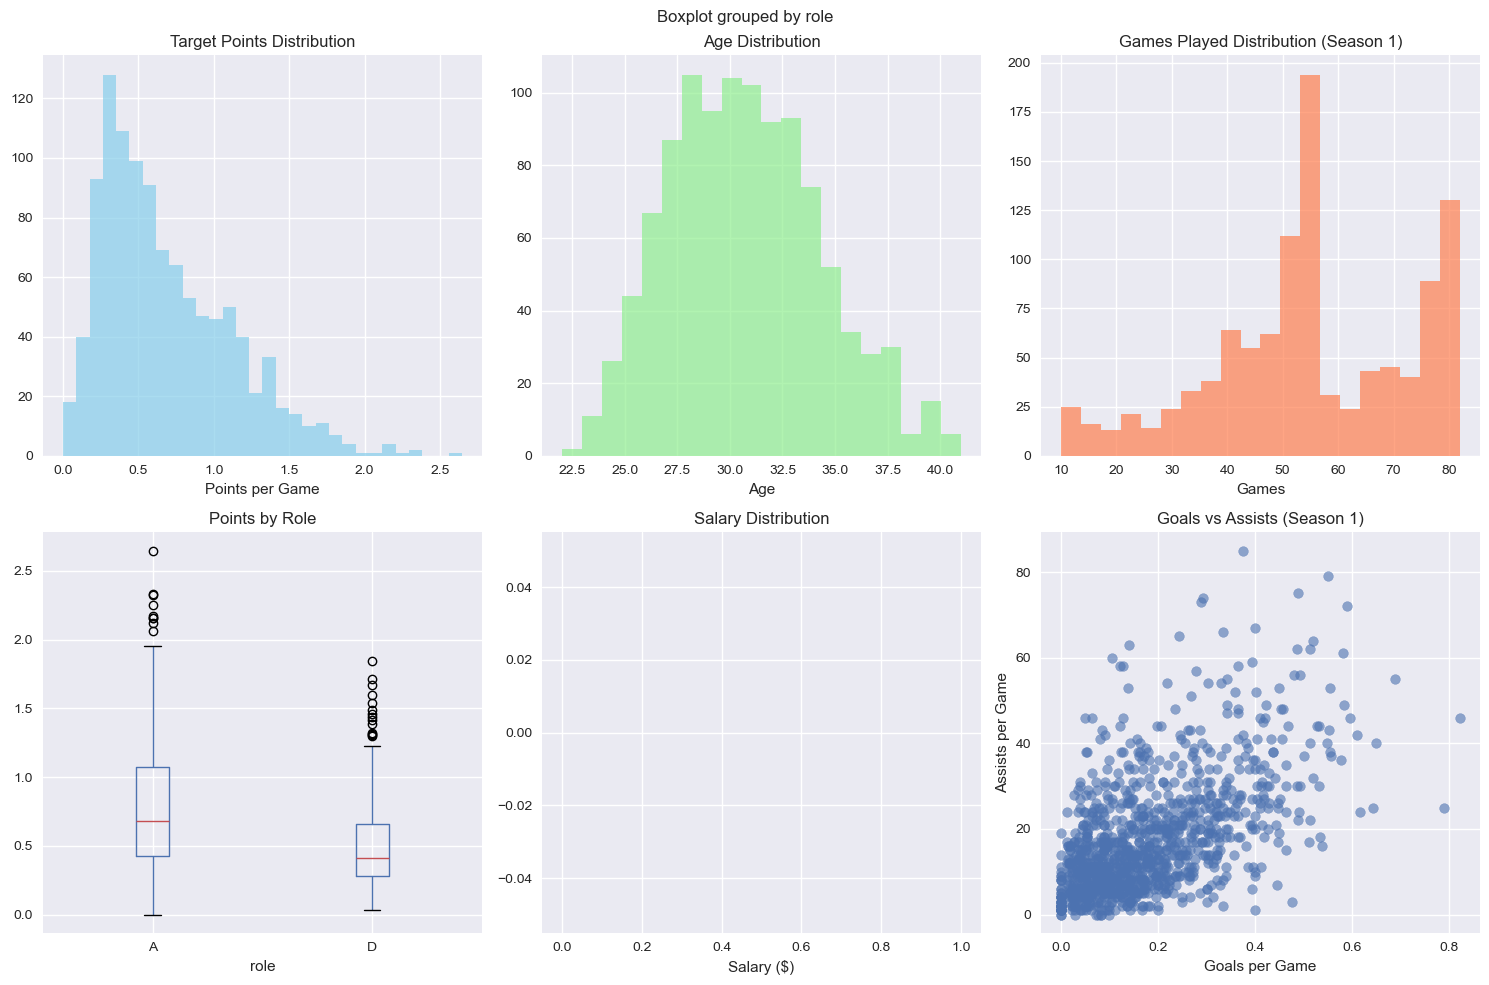

📊 Data visualization complete


In [11]:
# Visualize data distributions
if not training_df.empty:
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    
    # Target variable distribution
    axes[0,0].hist(training_df['target_points'], bins=30, alpha=0.7, color='skyblue')
    axes[0,0].set_title('Target Points Distribution')
    axes[0,0].set_xlabel('Points per Game')
    
    # Age distribution
    axes[0,1].hist(training_df['age'], bins=20, alpha=0.7, color='lightgreen')
    axes[0,1].set_title('Age Distribution')
    axes[0,1].set_xlabel('Age')
    
    # Games played distribution (season 1)
    axes[0,2].hist(training_df['games_1'] * 82, bins=20, alpha=0.7, color='coral')
    axes[0,2].set_title('Games Played Distribution (Season 1)')
    axes[0,2].set_xlabel('Games')
    
    # Points by role
    training_df.boxplot(column='target_points', by='role', ax=axes[1,0])
    axes[1,0].set_title('Points by Role')
    
    # Salary distribution (log scale)
    salary_data = training_df[training_df['salary'] < config.data.default_salary]['salary']
    axes[1,1].hist(salary_data, bins=30, alpha=0.7, color='gold')
    axes[1,1].set_title('Salary Distribution')
    axes[1,1].set_xlabel('Salary ($)')
    axes[1,1].ticklabel_format(style='scientific', axis='x', scilimits=(0,0))
    
    # Goals vs Assists correlation
    axes[1,2].scatter(training_df['goals_1'], training_df['assists_1'], alpha=0.6)
    axes[1,2].set_title('Goals vs Assists (Season 1)')
    axes[1,2].set_xlabel('Goals per Game')
    axes[1,2].set_ylabel('Assists per Game')
    
    plt.tight_layout()
    plt.show()
    
    print("📊 Data visualization complete")

## Prepare Current Season Data

Prepare data for the current season to make predictions.

In [12]:
# Prepare current season data for prediction
print(f"🎯 Preparing current season data for {config.data.current_season}...")

current_season_df = pipeline.prepare_current_season_data()

if not current_season_df.empty:
    print(f"\n✅ Current season dataset prepared with {len(current_season_df)} players")
    print(f"📊 Dataset shape: {current_season_df.shape}")
    
    # Show distribution by role
    print("\n📊 Current season players by role:")
    role_dist = current_season_df['role'].value_counts()
    for role, count in role_dist.items():
        role_name = {'A': 'Attackers', 'D': 'Defensemen', 'G': 'Goalies'}.get(role, role)
        print(f"  {role_name}: {count}")
        
    # Show salary statistics
    valid_salaries = current_season_df[current_season_df['salary'] < config.data.default_salary]['salary']
    print(f"\n💰 Salary statistics (excluding defaults):")
    print(f"  Players with known salaries: {len(valid_salaries)}/{len(current_season_df)}")
    if len(valid_salaries) > 0:
        print(f"  Average salary: ${valid_salaries.mean():,.0f}")
        print(f"  Median salary: ${valid_salaries.median():,.0f}")
        print(f"  Salary range: ${valid_salaries.min():,.0f} - ${valid_salaries.max():,.0f}")
else:
    print("❌ No current season data could be prepared")

2025-09-19 00:28:25,013 - INFO - Preparing current season data for 20232024
2025-09-19 00:28:25,013 - INFO - Player points data for 20232024 already exists, skipping download
2025-09-19 00:28:25,017 - INFO - Found 32 teams for season 20232024: ['TBL', 'COL', 'EDM', 'NYR', 'BOS', 'TOR', 'VAN', 'MIN', 'FLA', 'NSH', 'PIT', 'CAR', 'STL', 'NJD', 'DAL', 'NYI', 'MTL', 'ARI', 'CGY', 'LAK', 'OTT', 'DET', 'WPG', 'VGK', 'PHI', 'WSH', 'SEA', 'CHI', 'ANA', 'SJS', 'CBJ', 'BUF']
2025-09-19 00:28:25,017 - INFO - Team TBL data for 20232024 already exists, skipping download
2025-09-19 00:28:25,018 - INFO - Found 32 players for team TBL in season 20232024
2025-09-19 00:28:25,018 - INFO - Player 8474564 data already exists, skipping download
2025-09-19 00:28:25,020 - WARNING - Salary file not found for season 20232024, using default salary
2025-09-19 00:28:25,020 - INFO - Player 8474567 data already exists, skipping download
2025-09-19 00:28:25,021 - WARNING - Salary file not found for season 20232024, us

🎯 Preparing current season data for 20232024...


2025-09-19 00:28:25,183 - INFO - Player 8480078 data already exists, skipping download
2025-09-19 00:28:25,184 - WARNING - Salary file not found for season 20232024, using default salary
2025-09-19 00:28:25,184 - INFO - Player 8480817 data already exists, skipping download
2025-09-19 00:28:25,186 - WARNING - Salary file not found for season 20232024, using default salary
2025-09-19 00:28:25,186 - INFO - Player 8481554 data already exists, skipping download
2025-09-19 00:28:25,187 - WARNING - Salary file not found for season 20232024, using default salary
2025-09-19 00:28:25,188 - INFO - Player 8481708 data already exists, skipping download
2025-09-19 00:28:25,188 - WARNING - Salary file not found for season 20232024, using default salary
2025-09-19 00:28:25,189 - INFO - Player 8481726 data already exists, skipping download
2025-09-19 00:28:25,189 - WARNING - Salary file not found for season 20232024, using default salary
2025-09-19 00:28:25,190 - INFO - Player 8482067 data already exis


✅ Current season dataset prepared with 709 players
📊 Dataset shape: (709, 27)

📊 Current season players by role:
  Attackers: 467
  Defensemen: 242

💰 Salary statistics (excluding defaults):
  Players with known salaries: 0/709


In [13]:
# Display sample of current season data
if not current_season_df.empty:
    print("🔍 Sample of current season data:")
    display(current_season_df[['name', 'role', 'age', 'salary', 'goals_1', 'assists_1', 'games_1']].head(10))

🔍 Sample of current season data:


,name,role,age,salary,goals_1,assists_1,games_1
0,Steven Stamkos,A,35,88000000,0.419753,50,0.987805
1,Victor Hedman,D,34,88000000,0.118421,40,0.926829
2,Calvin de Haan,D,34,88000000,0.037736,10,0.646341
3,Austin Watson,A,33,88000000,0.120000,2,0.914634
4,Nikita Kucherov,A,32,88000000,0.365854,83,1.000000
5,Luke Glendening,A,36,88000000,0.042857,3,0.853659
6,Mathew Dumba,D,31,88000000,0.050633,10,0.963415
7,Tyler Motte,A,30,88000000,0.078947,6,0.463415
8,Anthony Duclair,A,30,88000000,0.100000,7,0.243902
9,Nick Paul,A,30,88000000,0.212500,15,0.975610


## Save Processed Data

Save the processed datasets for use in machine learning models.

In [14]:
# Save processed datasets
print("💾 Saving processed datasets...")

# Create processed data directory
processed_dir = config.data.data_path / "processed"
processed_dir.mkdir(exist_ok=True)

# Save training data
if not training_df.empty:
    training_path = processed_dir / "training_dataset.csv"
    training_df.to_csv(training_path, index=False)
    print(f"✅ Training dataset saved to: {training_path}")
    
    # Also save as parquet for better performance
    training_parquet = processed_dir / "training_dataset.parquet"
    training_df.to_parquet(training_parquet, index=False)
    print(f"✅ Training dataset (parquet) saved to: {training_parquet}")

# Save current season data
if not current_season_df.empty:
    current_path = processed_dir / f"current_season_{config.data.current_season}.csv"
    current_season_df.to_csv(current_path, index=False)
    print(f"✅ Current season dataset saved to: {current_path}")
    
    current_parquet = processed_dir / f"current_season_{config.data.current_season}.parquet"
    current_season_df.to_parquet(current_parquet, index=False)
    print(f"✅ Current season dataset (parquet) saved to: {current_parquet}")

print(f"\n📁 All processed data saved in: {processed_dir}")

💾 Saving processed datasets...
✅ Training dataset saved to: data\processed\training_dataset.csv
✅ Training dataset (parquet) saved to: data\processed\training_dataset.parquet
✅ Current season dataset saved to: data\processed\current_season_20232024.csv
✅ Current season dataset (parquet) saved to: data\processed\current_season_20232024.parquet

📁 All processed data saved in: data\processed


## Export Summary Statistics

Generate and save a comprehensive summary of the data pipeline results.

In [15]:
# Export comprehensive summary
print("📈 Generating pipeline summary...")

summary_path = "nhl_data_pipeline_summary.json"
pipeline.export_summary_stats(summary_path)

print(f"✅ Pipeline summary saved to: {summary_path}")

# Read and display key summary statistics
import json
with open(summary_path, 'r') as f:
    summary = json.load(f)

print("\n📊 Pipeline Summary:")
print(f"Status: {summary['pipeline_status']}")
print(f"Valid seasons: {len(summary['data_integrity']['valid_seasons'])}/{summary['data_integrity']['seasons_checked']}")
print(f"Total teams: {summary['data_integrity']['total_teams']}")
print(f"Total players: {summary['data_integrity']['total_players']}")

if not training_df.empty:
    print(f"Training examples: {len(training_df)}")
if not current_season_df.empty:
    print(f"Current season players: {len(current_season_df)}")

2025-09-19 00:28:26,712 - INFO - Generating dataset summary statistics
2025-09-19 00:28:26,713 - INFO - Validating data integrity
2025-09-19 00:28:26,713 - INFO - Player points data for 20202021 already exists, skipping download
2025-09-19 00:28:26,716 - INFO - Found 31 teams for season 20202021: ['EDM', 'BOS', 'TOR', 'COL', 'CHI', 'WPG', 'PIT', 'VGK', 'FLA', 'STL', 'NYR', 'CAR', 'WSH', 'MIN', 'DAL', 'LAK', 'VAN', 'SJS', 'CGY', 'TBL', 'NYI', 'MTL', 'CBJ', 'ARI', 'PHI', 'BUF', 'DET', 'OTT', 'NJD', 'ANA', 'NSH']
2025-09-19 00:28:26,716 - INFO - Team EDM data for 20202021 already exists, skipping download
2025-09-19 00:28:26,717 - INFO - Found 28 players for team EDM in season 20202021
2025-09-19 00:28:26,717 - INFO - Player points data for 20212022 already exists, skipping download
2025-09-19 00:28:26,721 - INFO - Found 32 teams for season 20212022: ['EDM', 'CGY', 'FLA', 'MIN', 'TOR', 'TBL', 'VAN', 'NSH', 'NYR', 'WPG', 'COL', 'CHI', 'WSH', 'PIT', 'STL', 'CAR', 'DAL', 'BOS', 'SJS', 'NJD',

📈 Generating pipeline summary...
✅ Pipeline summary saved to: nhl_data_pipeline_summary.json

📊 Pipeline Summary:
Status: ready
Valid seasons: 4/4
Total teams: 127
Total players: 122
Training examples: 1073
Current season players: 709


## Next Steps

Your data pipeline is now ready! Here's what you can do next:

In [16]:
print("🎉 NHL Data Pipeline Setup Complete!")
print("\n🚀 Next Steps:")
print("1. ✅ Data downloaded and validated")
print("2. ✅ Training dataset created")
print("3. ✅ Current season data prepared")
print("4. 🔄 Ready for machine learning model training")
print("5. 🔄 Ready for team optimization")

print("\n📋 Available Datasets:")
if not training_df.empty:
    print(f"  📊 Training dataset: {len(training_df)} examples")
if not current_season_df.empty:
    print(f"  🎯 Current season: {len(current_season_df)} players")

print("\n🔧 Configuration:")
print(f"  📁 Data directory: {config.data.data_path}")
print(f"  🏒 Current season: {config.data.current_season}")
print(f"  💰 Salary cap: ${config.pool.salary_cap:,}")
print(f"  👥 Team composition: {config.pool.max_attackers}A/{config.pool.max_defensemen}D/{config.pool.max_goalies}G")

print("\n📚 To use this data in your ML models:")
print("```python")
print("# Load training data")
print("df = pd.read_parquet('data/processed/training_dataset.parquet')")
print("")
print("# Separate features and target")
print("X = df.drop(['target_points', 'player_id', 'name'], axis=1)")
print("y = df['target_points']")
print("```")

print("\n🎯 Ready to build your optimal NHL pool!")

🎉 NHL Data Pipeline Setup Complete!

🚀 Next Steps:
1. ✅ Data downloaded and validated
2. ✅ Training dataset created
3. ✅ Current season data prepared
4. 🔄 Ready for machine learning model training
5. 🔄 Ready for team optimization

📋 Available Datasets:
  📊 Training dataset: 1073 examples
  🎯 Current season: 709 players

🔧 Configuration:
  📁 Data directory: data
  🏒 Current season: 20232024
  💰 Salary cap: $88,000,000
  👥 Team composition: 12A/6D/2G

📚 To use this data in your ML models:
```python
# Load training data
df = pd.read_parquet('data/processed/training_dataset.parquet')

# Separate features and target
X = df.drop(['target_points', 'player_id', 'name'], axis=1)
y = df['target_points']
```

🎯 Ready to build your optimal NHL pool!
